### Module을 불러오고 장비확인

In [140]:
!pip install seaborn

In [141]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.optim as optim
import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from torch.utils.data import DataLoader, Dataset

import seaborn as sns

In [2]:
class TensorData(Dataset):
    # 외부에 있는 데이터를 가져오기 위해 외부에서 데이터가 들어올 수 있도록, x_data, y_data 변수를 지정
    def __init__(self, x_data, y_data):
        #들어온 x는 tensor형태로 변환
        self.x_data = torch.FloatTensor(x_data)
        # tensor data의 형태는 (배치사이즈, 채널사이즈, 이미지 너비, 높이)의 형태임
        # 따라서 들어온 데이터의 형식을 permute함수를 활용하여 바꾸어주어야함.
        # 아래는 이미지용
        #self.x_data = self.x_data.permute(0,3,1,2)  # 인덱스 번호로 바꾸어주는 것 # 이미지 개수, 채널 수, 이미지 너비, 높이
        self.y_data = torch.FloatTensor(y_data) # float tensor / long tensor 로 숫자 속성을 정해줄 수 있음
        self.len = self.y_data.shape[0]

    # x,y를 튜플형태로 바깥으로 내보내기
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [3]:

class NormalTransform():

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.Normalize(self,mean,std),
        ])

    def __call__(self, img):
        return self.data_transform(img)

### 딥러닝 모델 설계 장비 확인

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.11.0  Device: cuda


### 데이터 전처리

In [5]:
df  = pd.read_csv(".\colonoscopy\history\exp_20220413_131808.csv")

In [6]:
df

,time,.header.seq,.header.stamp.secs,.header.stamp.nsecs,.header.frame_id,.joy_x,.joy_y,.joy_r,.joy_f,.joy_fs
0,2022/04/13/13:17:22.388795,1,1649823442,388674497,NaN,-0.001953,0.629292,0.0,0.082369,4.0
1,2022/04/13/13:17:22.453359,2,1649823442,452596426,NaN,-0.007996,0.633351,0.0,0.024751,1.0
2,2022/04/13/13:17:22.516762,3,1649823442,516623497,NaN,-0.016449,0.644917,0.0,-0.000000,0.0
3,2022/04/13/13:17:22.580912,4,1649823442,580574274,NaN,-0.017762,0.661519,0.0,-0.000000,0.0
4,2022/04/13/13:17:22.644906,5,1649823442,644766807,NaN,-0.020356,0.679098,0.0,-0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
658,2022/04/13/13:18:04.498635,659,1649823484,498252391,NaN,0.000000,0.000000,-0.0,-0.000000,0.0
659,2022/04/13/13:18:04.562541,660,1649823484,562239408,NaN,0.000000,0.000000,-0.0,-0.000000,0.0
660,2022/04/13/13:18:04.626632,661,1649823484,626288175,NaN,0.000000,0.000000,-0.0,-0.000000,0.0
661,2022/04/13/13:18:04.690758,662,1649823484,690424919,NaN,0.000000,0.000000,-0.0,-0.000000,0.0


In [7]:
index = [".joy_x", ".joy_y"]

In [8]:
df.index

RangeIndex(start=0, stop=663, step=1)

In [9]:
df = df[index]

In [10]:
df

,.joy_x,.joy_y
0,-0.001953,0.629292
1,-0.007996,0.633351
2,-0.016449,0.644917
3,-0.017762,0.661519
4,-0.020356,0.679098
...,...,...
658,0.000000,0.000000
659,0.000000,0.000000
660,0.000000,0.000000
661,0.000000,0.000000


In [11]:
label = pd.read_csv(".\colonoscopy\labels\exp_20220413-131808.csv")

In [12]:
label_index = ["X","Y"]

In [13]:
label = label[label_index]

In [14]:
label

,X,Y
0,325,469
1,324,469
2,324,469
3,324,469
4,324,469
...,...,...
658,12,467
659,12,467
660,11,473
661,9,474


In [15]:
df_x = np.array(df[".joy_x"])

In [16]:
df_y = np.array(df[".joy_y"])

In [17]:
label_x = np.array(label["X"])

In [18]:
label_y = np.array(label["Y"])

In [19]:
np.array(df_x).mean()

-0.24501534450242962

#### normalization [0,1]

In [20]:
df_x_n = (df_x - np.min(df_x))/np.ptp(df_x);
df_y_n = (df_y - np.min(df_y))/np.ptp(df_y);
label_x_n = (label_x - np.min(label_x))/np.ptp(label_x);
label_y_n = (label_y - np.min(label_y))/np.ptp(label_y);


In [21]:
a=torch.tensor([df_x_n[0:0+15],df_y_n[0:0+15]])

C:\Users\raist\Miniconda3\envs\machin\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  """Entry point for launching an IPython kernel.


In [22]:
np.transpose(a)

tensor([[0.5162, 0.7546],
        [0.5131, 0.7572],
        [0.5087, 0.7649],
        [0.5081, 0.7759],
        [0.5067, 0.7875],
        [0.5067, 0.8029],
        [0.5067, 0.8158],
        [0.5015, 0.8385],
        [0.4994, 0.8526],
        [0.4980, 0.8614],
        [0.4943, 0.8632],
        [0.4858, 0.8632],
        [0.4704, 0.8612],
        [0.4592, 0.8612],
        [0.4544, 0.8638]], dtype=torch.float64)

In [23]:
len(df_x_n)

663

### input : pixel -----> output : joystick

In [24]:
df_x_n = (df_x - np.min(df_x))/np.ptp(df_x);
df_y_n = (df_y - np.min(df_y))/np.ptp(df_y);
label_x_n = (label_x - np.min(label_x))/np.ptp(label_x);
label_y_n = (label_y - np.min(label_y))/np.ptp(label_y);


In [42]:
temp_x = torch.zeros(649,15,2)
temp_y = torch.zeros(649,1,2)
for i in range(0,649):
    temp_x[i]=np.transpose(torch.tensor([label_x_n[i:i+15],label_y_n[i:i+15]]))

for i in range(0,649):
    temp_y[i] = torch.tensor([df_x_n[i+14:i+15].item(),df_y_n[i+14:i+15].item()])

### dataset 생성

In [26]:
train_data = TensorData(temp_x, temp_y)

In [43]:
BATCH_SIZE = 20

train = TensorData(temp_x[0:int(649*0.7)],temp_y[0:int(649*0.7)])
val = TensorData(temp_x[int(649*0.7):int(649*0.85)],temp_y[int(649*0.7):int(649*0.85)])
test = TensorData(temp_x[int(649*0.85):649],temp_y[int(649*0.85):649])

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=BATCH_SIZE, shuffle=False)

In [77]:
val.x_data.size()

torch.Size([97, 15, 2])

In [36]:
#train_data_x = TensorData(df_x_n, label_x_n)

In [37]:
#train_data_y = TensorData(df_y_n, label_y_n)

### 모델 생성

In [328]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self,kernel = 5,in_channel=2, out_channel=2,out_channels=32,middle=1024,final = 1024):
        super(Model, self).__init__()
        self.conv1d_1 = nn.Conv1d(in_channels=in_channel,
                                   out_channels=out_channels,
                                   kernel_size = kernel,
                                   stride = 1)

        self.fc3 = nn.Linear((15-kernel+1)*out_channels,middle)
        #self.fc2 = nn.Linear(middle,final)
        self.fc1 = nn.Linear(middle,out_channel)
            
        self.relu = nn.ReLU()
            
        self.sigmoid = nn.Sigmoid()
            
            
        self.flat = nn.Flatten()
        
    def forward(self,x): 
        # Raw x shape : (B, S, F)
        # Shape : (B, F, S)
        #print(x.size())
        x = x.transpose(1,2)
        
        # Shape : (B, F, S) == (B, C, S)
        x = self.conv1d_1(x)
        # Shape : (B, C, S) 
        #print(x.size())
        x = self.flat(x)
        #x = x.transpose(1,2)
        x = self.fc3(x)
        #print(x.size())
        #x = self.relu(x)
        x = self.relu(x)
        #x = self.fc2(x)
        #x = self.relu(x)
        x = self.fc1(x)
        #print(x.size())
                     
                    
                     
        
        return x



### 가중치 초기화

#### 초기화를 위한 함수 만들기

In [329]:
def init_constants(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight.data,0)
        nn.init.constant_(m.bias.data, 0)
        
def init_normal(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 1.0)
        nn.init.normal_(m.bias, 0, 1.0)

def init_xaiver(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight, 1.0)

        
def init_kaiming(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, 0, mode='fan_in', nonlinearity='relu')

### 학습하기


In [791]:
def training_epoch(train_loader, network, loss_func, optimizer, epoch):
    train_losses = []
    train_correct = 0
    log_interval = 300
    
    
    for batch_idx, (xb, label) in enumerate(train_loader):       
        
        xb, label = xb.to(device), label.to(device)
        #print(xb)
        batch_size = xb.size()[0]
        #xb = xb.view(batch_size,-1)
        label = label.view(batch_size,-1)
        #print(label.size())
        # 미분값의 초기화
        optimizer.zero_grad()
        #xb = xb.view(xb.shape[0],1)
        #Forward propagation 계산
        outputs = network(xb)
        
        # MSE 함수로 로스 구하기

        loss = loss_func(outputs,label)
        train_losses.append(loss.item())

        # Gradinet 구하기
        loss.backward()

        # weight값 update 하기
        optimizer.step()

        # 학습 상황 출력
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.2f}%)]\tLoss: {:.6f}'
                  .format(epoch+1, batch_idx * len(label), len(train_loader.dataset),100. * batch_idx / len(train_loader),
                          loss.item()))
            
    return train_losses

In [783]:
def test_epoch(test_loader, network, loss_func, val = False):
    correct = 0
    
    test_losses = []
    
    with torch.no_grad():
        for batch_idx, (xb, label) in enumerate(test_loader):
            xb, label = xb.to(device), label.to(device)
            batch_size = xb.size()[0]
            #xb = xb.view(batch_size,-1)
            label = label.view(batch_size,-1)
            #image = image.view([-1 , 1, 5])
            # Forward propagration 계산하기.
            outputs= network(xb)

            # MSE 함수를 적용하여 loss를 구하기
            loss = loss_func(outputs, label)
            test_losses.append(loss.item())
            avg_loss = np.mean(test_losses)


        #중간결과 출력
        if val is True:
            print('Validation set: Loss: {:.5f}\n'.format(avg_loss))
        
        else:
            print('Test set: Loss: {:.5f}\n'.format(avg_loss))
        
    return test_losses


### 정의된 함수로 학습 함수 만들기

In [556]:
def training(network, learning_rate = 0.001, epoches = 100):
    
    
    cls_loss = torch.nn.MSELoss().to(device)
    optimizer =torch.optim.Adam(network.parameters(),learning_rate)
    
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    test_losses_per_epoch = []
  
    for epoch in range(epoches):
                
        # 모델를 학습 중이라고 선언하기
        network.train()
        
        train_losses = training_epoch(train_loader,network,cls_loss,optimizer, epoch)
        
        # epoch 별로 loss 평균값, 정확도 구하기
        average_loss = np.mean(train_losses)
        train_losses_per_epoch.append(average_loss)
        
        
        # epoch 별로 정확도 출력
        print('\nTraining set: Loss {:.6f}'.format(average_loss))

        
        ### 학습 중에 test 결과 보기
        
        # 모델 test 중인 것을 선언하기
        network.eval()
        
        correct = 0
        with torch.no_grad():
            val_losses = test_epoch(val_loader, network, cls_loss, True)

        val_losses_per_epoch.append(np.mean(val_losses))
        
    with torch.no_grad():
        test_losses = test_epoch(test_loader, network, cls_loss, False)
        
    
        
    return train_losses_per_epoch,val_losses_per_epoch


### x 훈련

In [966]:
model1 = Model(kernel=5,out_channels=64,middle =256)
model1 = model1.cuda()
model1 = model1.apply(init_kaiming)     # relu
#model1 = model1.apply(init_xaiver)      # sigmoid
loss = nn.MSELoss()


In [957]:

train_loss, val_loss  = training(model1,0.0007,1000)

Train Epoch: 1 [0/454 (0.00%)]	Loss: 0.658644

Training set: Loss 0.232301
Validation set: Loss: 0.06678

Train Epoch: 2 [0/454 (0.00%)]	Loss: 0.076388

Training set: Loss 0.049178
Validation set: Loss: 0.03327

Train Epoch: 3 [0/454 (0.00%)]	Loss: 0.031108

Training set: Loss 0.074895
Validation set: Loss: 0.03373

Train Epoch: 4 [0/454 (0.00%)]	Loss: 0.024103

Training set: Loss 0.076569
Validation set: Loss: 0.04547

Train Epoch: 5 [0/454 (0.00%)]	Loss: 0.103929

Training set: Loss 0.094059
Validation set: Loss: 0.04911

Train Epoch: 6 [0/454 (0.00%)]	Loss: 0.069394

Training set: Loss 0.070484
Validation set: Loss: 0.05152

Train Epoch: 7 [0/454 (0.00%)]	Loss: 0.172032

Training set: Loss 0.090244
Validation set: Loss: 0.06388

Train Epoch: 8 [0/454 (0.00%)]	Loss: 0.051971

Training set: Loss 0.049905
Validation set: Loss: 0.03294

Train Epoch: 9 [0/454 (0.00%)]	Loss: 0.009278

Training set: Loss 0.040622
Validation set: Loss: 0.02845

Train Epoch: 10 [0/454 (0.00%)]	Loss: 0.001577


Training set: Loss 0.023270
Validation set: Loss: 0.02181

Train Epoch: 81 [0/454 (0.00%)]	Loss: 0.010376

Training set: Loss 0.023047
Validation set: Loss: 0.02246

Train Epoch: 82 [0/454 (0.00%)]	Loss: 0.010458

Training set: Loss 0.023228
Validation set: Loss: 0.02221

Train Epoch: 83 [0/454 (0.00%)]	Loss: 0.010275

Training set: Loss 0.023043
Validation set: Loss: 0.02194

Train Epoch: 84 [0/454 (0.00%)]	Loss: 0.010320

Training set: Loss 0.022966
Validation set: Loss: 0.02246

Train Epoch: 85 [0/454 (0.00%)]	Loss: 0.010159

Training set: Loss 0.022935
Validation set: Loss: 0.02225

Train Epoch: 86 [0/454 (0.00%)]	Loss: 0.010248

Training set: Loss 0.022976
Validation set: Loss: 0.02263

Train Epoch: 87 [0/454 (0.00%)]	Loss: 0.010148

Training set: Loss 0.022804
Validation set: Loss: 0.02242

Train Epoch: 88 [0/454 (0.00%)]	Loss: 0.010082

Training set: Loss 0.022820
Validation set: Loss: 0.02249

Train Epoch: 89 [0/454 (0.00%)]	Loss: 0.010378

Training set: Loss 0.022730
Validati


Training set: Loss 0.019716
Validation set: Loss: 0.02603

Train Epoch: 160 [0/454 (0.00%)]	Loss: 0.011887

Training set: Loss 0.020437
Validation set: Loss: 0.02449

Train Epoch: 161 [0/454 (0.00%)]	Loss: 0.009392

Training set: Loss 0.019304
Validation set: Loss: 0.02440

Train Epoch: 162 [0/454 (0.00%)]	Loss: 0.010734

Training set: Loss 0.020366
Validation set: Loss: 0.02325

Train Epoch: 163 [0/454 (0.00%)]	Loss: 0.006853

Training set: Loss 0.019800
Validation set: Loss: 0.02697

Train Epoch: 164 [0/454 (0.00%)]	Loss: 0.008885

Training set: Loss 0.019843
Validation set: Loss: 0.03049

Train Epoch: 165 [0/454 (0.00%)]	Loss: 0.014854

Training set: Loss 0.019997
Validation set: Loss: 0.02594

Train Epoch: 166 [0/454 (0.00%)]	Loss: 0.011171

Training set: Loss 0.019023
Validation set: Loss: 0.02202

Train Epoch: 167 [0/454 (0.00%)]	Loss: 0.007288

Training set: Loss 0.018702
Validation set: Loss: 0.02326

Train Epoch: 168 [0/454 (0.00%)]	Loss: 0.010811

Training set: Loss 0.019795


Training set: Loss 0.018321
Validation set: Loss: 0.02651

Train Epoch: 240 [0/454 (0.00%)]	Loss: 0.008432

Training set: Loss 0.018256
Validation set: Loss: 0.02624

Train Epoch: 241 [0/454 (0.00%)]	Loss: 0.010564

Training set: Loss 0.019006
Validation set: Loss: 0.02736

Train Epoch: 242 [0/454 (0.00%)]	Loss: 0.008855

Training set: Loss 0.018138
Validation set: Loss: 0.02820

Train Epoch: 243 [0/454 (0.00%)]	Loss: 0.010294

Training set: Loss 0.019228
Validation set: Loss: 0.02624

Train Epoch: 244 [0/454 (0.00%)]	Loss: 0.012097

Training set: Loss 0.020494
Validation set: Loss: 0.02404

Train Epoch: 245 [0/454 (0.00%)]	Loss: 0.013892

Training set: Loss 0.020862
Validation set: Loss: 0.02706

Train Epoch: 246 [0/454 (0.00%)]	Loss: 0.010437

Training set: Loss 0.019244
Validation set: Loss: 0.02689

Train Epoch: 247 [0/454 (0.00%)]	Loss: 0.010339

Training set: Loss 0.019495
Validation set: Loss: 0.02725

Train Epoch: 248 [0/454 (0.00%)]	Loss: 0.008122

Training set: Loss 0.018314

Validation set: Loss: 0.03122

Train Epoch: 320 [0/454 (0.00%)]	Loss: 0.010317

Training set: Loss 0.017817
Validation set: Loss: 0.02939

Train Epoch: 321 [0/454 (0.00%)]	Loss: 0.010061

Training set: Loss 0.018363
Validation set: Loss: 0.03181

Train Epoch: 322 [0/454 (0.00%)]	Loss: 0.009921

Training set: Loss 0.017567
Validation set: Loss: 0.03076

Train Epoch: 323 [0/454 (0.00%)]	Loss: 0.008987

Training set: Loss 0.018269
Validation set: Loss: 0.03166

Train Epoch: 324 [0/454 (0.00%)]	Loss: 0.010446

Training set: Loss 0.018313
Validation set: Loss: 0.02899

Train Epoch: 325 [0/454 (0.00%)]	Loss: 0.010622

Training set: Loss 0.018980
Validation set: Loss: 0.03196

Train Epoch: 326 [0/454 (0.00%)]	Loss: 0.009982

Training set: Loss 0.017825
Validation set: Loss: 0.03034

Train Epoch: 327 [0/454 (0.00%)]	Loss: 0.009303

Training set: Loss 0.018212
Validation set: Loss: 0.03141

Train Epoch: 328 [0/454 (0.00%)]	Loss: 0.009918

Training set: Loss 0.017649
Validation set: Loss: 0.0309


Training set: Loss 0.016625
Validation set: Loss: 0.03584

Train Epoch: 399 [0/454 (0.00%)]	Loss: 0.009368

Training set: Loss 0.016248
Validation set: Loss: 0.03564

Train Epoch: 400 [0/454 (0.00%)]	Loss: 0.011076

Training set: Loss 0.016569
Validation set: Loss: 0.03434

Train Epoch: 401 [0/454 (0.00%)]	Loss: 0.009014

Training set: Loss 0.016429
Validation set: Loss: 0.03703

Train Epoch: 402 [0/454 (0.00%)]	Loss: 0.010122

Training set: Loss 0.016279
Validation set: Loss: 0.03515

Train Epoch: 403 [0/454 (0.00%)]	Loss: 0.010411

Training set: Loss 0.016640
Validation set: Loss: 0.03512

Train Epoch: 404 [0/454 (0.00%)]	Loss: 0.009377

Training set: Loss 0.016174
Validation set: Loss: 0.03671

Train Epoch: 405 [0/454 (0.00%)]	Loss: 0.010257

Training set: Loss 0.016384
Validation set: Loss: 0.03485

Train Epoch: 406 [0/454 (0.00%)]	Loss: 0.010106

Training set: Loss 0.016519
Validation set: Loss: 0.03605

Train Epoch: 407 [0/454 (0.00%)]	Loss: 0.009435

Training set: Loss 0.016195


Training set: Loss 0.016759
Validation set: Loss: 0.03750

Train Epoch: 479 [0/454 (0.00%)]	Loss: 0.008209

Training set: Loss 0.016934
Validation set: Loss: 0.03897

Train Epoch: 480 [0/454 (0.00%)]	Loss: 0.012195

Training set: Loss 0.016406
Validation set: Loss: 0.03748

Train Epoch: 481 [0/454 (0.00%)]	Loss: 0.008556

Training set: Loss 0.016782
Validation set: Loss: 0.03726

Train Epoch: 482 [0/454 (0.00%)]	Loss: 0.012509

Training set: Loss 0.016526
Validation set: Loss: 0.03769

Train Epoch: 483 [0/454 (0.00%)]	Loss: 0.008150

Training set: Loss 0.016774
Validation set: Loss: 0.03616

Train Epoch: 484 [0/454 (0.00%)]	Loss: 0.012916

Training set: Loss 0.016840
Validation set: Loss: 0.03667

Train Epoch: 485 [0/454 (0.00%)]	Loss: 0.007563

Training set: Loss 0.016773
Validation set: Loss: 0.03641

Train Epoch: 486 [0/454 (0.00%)]	Loss: 0.012716

Training set: Loss 0.016698
Validation set: Loss: 0.03649

Train Epoch: 487 [0/454 (0.00%)]	Loss: 0.007694

Training set: Loss 0.016629


Training set: Loss 0.014635
Validation set: Loss: 0.03534

Train Epoch: 555 [0/454 (0.00%)]	Loss: 0.010416

Training set: Loss 0.014507
Validation set: Loss: 0.03631

Train Epoch: 556 [0/454 (0.00%)]	Loss: 0.007373

Training set: Loss 0.014913
Validation set: Loss: 0.03426

Train Epoch: 557 [0/454 (0.00%)]	Loss: 0.011745

Training set: Loss 0.014750
Validation set: Loss: 0.03274

Train Epoch: 558 [0/454 (0.00%)]	Loss: 0.006701

Training set: Loss 0.014944
Validation set: Loss: 0.03607

Train Epoch: 559 [0/454 (0.00%)]	Loss: 0.011471

Training set: Loss 0.014782
Validation set: Loss: 0.03574

Train Epoch: 560 [0/454 (0.00%)]	Loss: 0.006927

Training set: Loss 0.015085
Validation set: Loss: 0.03456

Train Epoch: 561 [0/454 (0.00%)]	Loss: 0.011567

Training set: Loss 0.014797
Validation set: Loss: 0.03258

Train Epoch: 562 [0/454 (0.00%)]	Loss: 0.006644

Training set: Loss 0.014989
Validation set: Loss: 0.03611

Train Epoch: 563 [0/454 (0.00%)]	Loss: 0.011186

Training set: Loss 0.014641

Validation set: Loss: 0.03484

Train Epoch: 635 [0/454 (0.00%)]	Loss: 0.012252

Training set: Loss 0.014087
Validation set: Loss: 0.03522

Train Epoch: 636 [0/454 (0.00%)]	Loss: 0.006384

Training set: Loss 0.014130
Validation set: Loss: 0.03355

Train Epoch: 637 [0/454 (0.00%)]	Loss: 0.012441

Training set: Loss 0.014190
Validation set: Loss: 0.03090

Train Epoch: 638 [0/454 (0.00%)]	Loss: 0.006464

Training set: Loss 0.014129
Validation set: Loss: 0.03500

Train Epoch: 639 [0/454 (0.00%)]	Loss: 0.012156

Training set: Loss 0.014013
Validation set: Loss: 0.03544

Train Epoch: 640 [0/454 (0.00%)]	Loss: 0.006485

Training set: Loss 0.014169
Validation set: Loss: 0.03291

Train Epoch: 641 [0/454 (0.00%)]	Loss: 0.012930

Training set: Loss 0.014306
Validation set: Loss: 0.03067

Train Epoch: 642 [0/454 (0.00%)]	Loss: 0.006102

Training set: Loss 0.014223
Validation set: Loss: 0.03476

Train Epoch: 643 [0/454 (0.00%)]	Loss: 0.013014

Training set: Loss 0.014282
Validation set: Loss: 0.0354


Training set: Loss 0.014070
Validation set: Loss: 0.03162

Train Epoch: 714 [0/454 (0.00%)]	Loss: 0.005747

Training set: Loss 0.013744
Validation set: Loss: 0.03555

Train Epoch: 715 [0/454 (0.00%)]	Loss: 0.012609

Training set: Loss 0.013794
Validation set: Loss: 0.03501

Train Epoch: 716 [0/454 (0.00%)]	Loss: 0.005924

Training set: Loss 0.013891
Validation set: Loss: 0.03379

Train Epoch: 717 [0/454 (0.00%)]	Loss: 0.013168

Training set: Loss 0.014218
Validation set: Loss: 0.03181

Train Epoch: 718 [0/454 (0.00%)]	Loss: 0.006146

Training set: Loss 0.013431
Validation set: Loss: 0.03485

Train Epoch: 719 [0/454 (0.00%)]	Loss: 0.010860

Training set: Loss 0.013483
Validation set: Loss: 0.03596

Train Epoch: 720 [0/454 (0.00%)]	Loss: 0.006924

Training set: Loss 0.013649
Validation set: Loss: 0.03319

Train Epoch: 721 [0/454 (0.00%)]	Loss: 0.012134

Training set: Loss 0.013827
Validation set: Loss: 0.03158

Train Epoch: 722 [0/454 (0.00%)]	Loss: 0.005986

Training set: Loss 0.013475


Training set: Loss 0.013236
Validation set: Loss: 0.03567

Train Epoch: 794 [0/454 (0.00%)]	Loss: 0.005871

Training set: Loss 0.013181
Validation set: Loss: 0.03596

Train Epoch: 795 [0/454 (0.00%)]	Loss: 0.012258

Training set: Loss 0.013383
Validation set: Loss: 0.03406

Train Epoch: 796 [0/454 (0.00%)]	Loss: 0.006041

Training set: Loss 0.013355
Validation set: Loss: 0.03395

Train Epoch: 797 [0/454 (0.00%)]	Loss: 0.011933

Training set: Loss 0.013410
Validation set: Loss: 0.03381

Train Epoch: 798 [0/454 (0.00%)]	Loss: 0.005465

Training set: Loss 0.013346
Validation set: Loss: 0.03751

Train Epoch: 799 [0/454 (0.00%)]	Loss: 0.012444

Training set: Loss 0.013458
Validation set: Loss: 0.03402

Train Epoch: 800 [0/454 (0.00%)]	Loss: 0.006390

Training set: Loss 0.013520
Validation set: Loss: 0.03266

Train Epoch: 801 [0/454 (0.00%)]	Loss: 0.011293

Training set: Loss 0.013435
Validation set: Loss: 0.03332

Train Epoch: 802 [0/454 (0.00%)]	Loss: 0.005925

Training set: Loss 0.013352

Validation set: Loss: 0.03659

Train Epoch: 872 [0/454 (0.00%)]	Loss: 0.006102

Training set: Loss 0.013270
Validation set: Loss: 0.03472

Train Epoch: 873 [0/454 (0.00%)]	Loss: 0.013414

Training set: Loss 0.013527
Validation set: Loss: 0.03263

Train Epoch: 874 [0/454 (0.00%)]	Loss: 0.005858

Training set: Loss 0.013095
Validation set: Loss: 0.03622

Train Epoch: 875 [0/454 (0.00%)]	Loss: 0.011169

Training set: Loss 0.013141
Validation set: Loss: 0.03669

Train Epoch: 876 [0/454 (0.00%)]	Loss: 0.006030

Training set: Loss 0.013273
Validation set: Loss: 0.03450

Train Epoch: 877 [0/454 (0.00%)]	Loss: 0.013381

Training set: Loss 0.013565
Validation set: Loss: 0.03255

Train Epoch: 878 [0/454 (0.00%)]	Loss: 0.005683

Training set: Loss 0.013091
Validation set: Loss: 0.03622

Train Epoch: 879 [0/454 (0.00%)]	Loss: 0.011343

Training set: Loss 0.013146
Validation set: Loss: 0.03667

Train Epoch: 880 [0/454 (0.00%)]	Loss: 0.005999

Training set: Loss 0.013203
Validation set: Loss: 0.0348


Training set: Loss 0.012999
Validation set: Loss: 0.03667

Train Epoch: 950 [0/454 (0.00%)]	Loss: 0.006059

Training set: Loss 0.012985
Validation set: Loss: 0.03538

Train Epoch: 951 [0/454 (0.00%)]	Loss: 0.012869

Training set: Loss 0.013328
Validation set: Loss: 0.03265

Train Epoch: 952 [0/454 (0.00%)]	Loss: 0.006294

Training set: Loss 0.012879
Validation set: Loss: 0.03505

Train Epoch: 953 [0/454 (0.00%)]	Loss: 0.010980

Training set: Loss 0.012974
Validation set: Loss: 0.03693

Train Epoch: 954 [0/454 (0.00%)]	Loss: 0.006108

Training set: Loss 0.012716
Validation set: Loss: 0.03722

Train Epoch: 955 [0/454 (0.00%)]	Loss: 0.011842

Training set: Loss 0.012947
Validation set: Loss: 0.03414

Train Epoch: 956 [0/454 (0.00%)]	Loss: 0.006701

Training set: Loss 0.012915
Validation set: Loss: 0.03366

Train Epoch: 957 [0/454 (0.00%)]	Loss: 0.011141

Training set: Loss 0.012969
Validation set: Loss: 0.03524

Train Epoch: 958 [0/454 (0.00%)]	Loss: 0.005630

Training set: Loss 0.012926

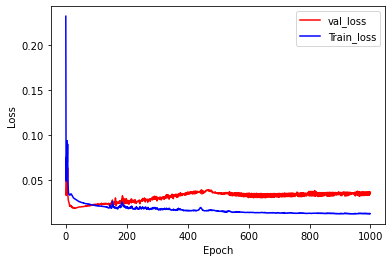

In [958]:
#plt.plot(test_loss,'r',label = 'Test_loss')
plt.plot(val_loss,'r',label = 'val_loss')
plt.plot(train_loss,'b',label = 'Train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

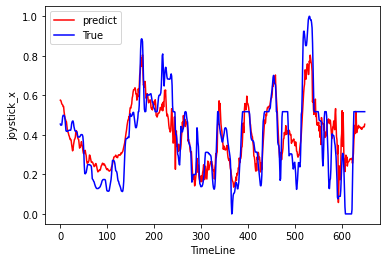

In [968]:
plt.plot(model1(temp_x.to(device))[:,0].detach().cpu(),'r', label='predict')
plt.plot(df_x_n[14:664],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_x')
plt.legend()

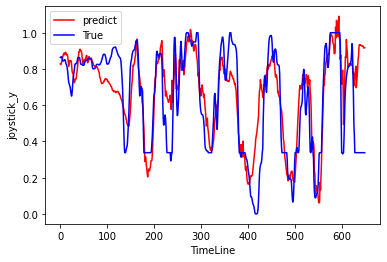

In [969]:
plt.plot(model1(temp_x.to(device))[:,1].detach().cpu(),'r', label='predict')
plt.plot(df_y_n[14:],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_y')
plt.legend()

In [737]:
len(model1(temp_x.to(device))[:,1].detach().cpu())

649

In [738]:
len(df_y_n[14:])

649

In [739]:
test.y_data.size()

torch.Size([98, 1, 2])

### 전체 경향성

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


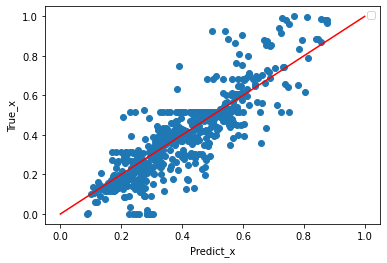

In [892]:
plt.scatter(model1(temp_x.to(device))[:,0].detach().cpu(),df_x_n[14:664])
plt.plot([0,1],[0,1],'red')
plt.plot(t,t,color='red')
plt.xlabel('Predict_x')
plt.ylabel('True_x')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


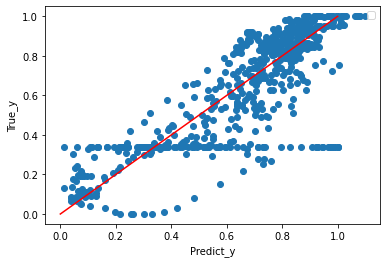

In [893]:
plt.scatter(model1(temp_x.to(device))[:,1].detach().cpu(),df_y_n[14:664])
plt.plot([0,1],[0,1],'red')
plt.xlabel('Predict_y')
plt.ylabel('True_y')
plt.legend()

### validation 경향성

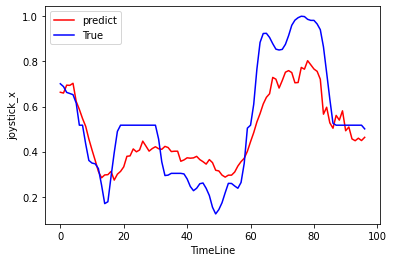

In [970]:
plt.plot(model1(val.x_data.to(device))[:,0].detach().cpu(),'r', label='predict')
plt.plot(val.y_data[:,:,0],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_x')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


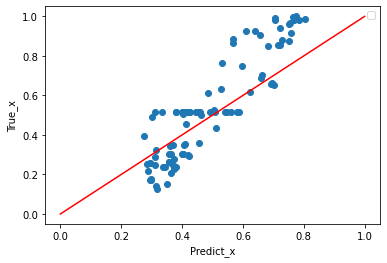

In [971]:
plt.scatter(model1(val.x_data.to(device))[:,0].detach().cpu(),val.y_data[:,:,0])
plt.plot([0,1],[0,1],'red')
plt.xlabel('Predict_x')
plt.ylabel('True_x')
plt.legend()

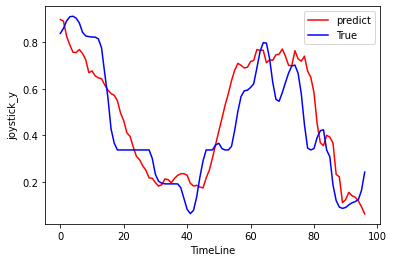

In [978]:
plt.plot(model1(val.x_data.to(device))[:,1].detach().cpu(),'r', label='predict')
plt.plot(val.y_data[:,:,1],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_y')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


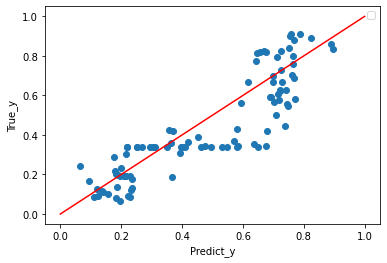

In [979]:
plt.scatter(model1(val.x_data.to(device))[:,1].detach().cpu(),val.y_data[:,:,1])
plt.plot([0,1],[0,1],'red')
plt.xlabel('Predict_y')
plt.ylabel('True_y')
plt.legend()

### testset 경향성

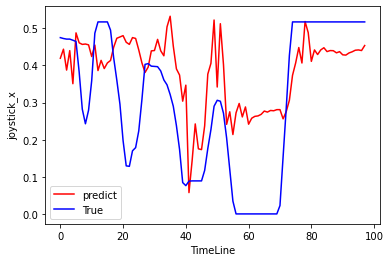

In [974]:
plt.plot(model1(test.x_data.to(device))[:,0].detach().cpu(),'r', label='predict')
plt.plot(test.y_data[:,:,0],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_x')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


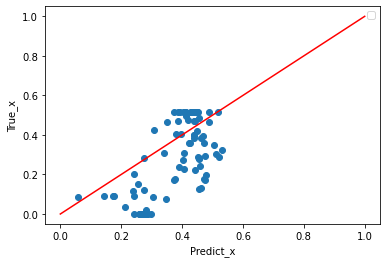

In [975]:
plt.scatter(model1(test.x_data.to(device))[:,0].detach().cpu(),test.y_data[:,:,0])
plt.plot([0,1],[0,1],'red')
plt.xlabel('Predict_x')
plt.ylabel('True_x')
plt.legend()

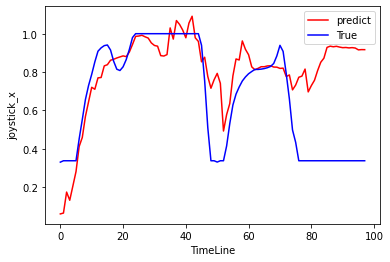

In [976]:
plt.plot(model1(test.x_data.to(device))[:,1].detach().cpu(),'r', label='predict')
plt.plot(test.y_data[:,:,1],'b',label='True')
plt.xlabel('TimeLine')
plt.ylabel('joystick_x')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


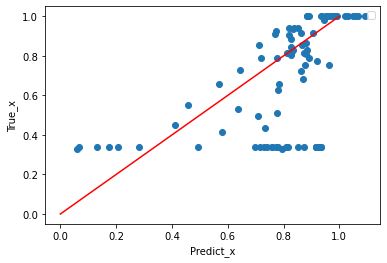

In [977]:
plt.scatter(model1(test.x_data.to(device))[:,1].detach().cpu(),test.y_data[:,:,1])
plt.plot([0,1],[0,1],'red')
plt.xlabel('Predict_x')
plt.ylabel('True_x')
plt.legend()

###  모델저장

In [241]:
PATH = 'C:\song\colonoscopy\weight/'

In [849]:
torch.save(model1, PATH + 'model_CNN_reverse_1lay.pt')
torch.save(model1.state_dict(), PATH + 'model_CNN_reverse_state_dict_1lay.pt')


### model 불러오기

In [967]:
model1.load_state_dict(torch.load(PATH + 'model_CNN_reverse_state_dict_1lay.pt'))
model1.to(device)

Model(
  (conv1d_1): Conv1d(2, 64, kernel_size=(5,), stride=(1,))
  (fc3): Linear(in_features=704, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=2, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [358]:
model1 = torch.load( PATH + 'model_CNN_reverse.pt')